In [1]:
from src import simulate as sim
from src import statistical_tests as st, data_prep, power_analysis as pa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# list of available hypotheses
sim_results = sim.generate_data_for_simulation()
list(st.run_all_tests(data_prep.get_winners_and_losers_dfs(sim_results), sim_results['outcomes']).keys())

['does_ai_have_effect',
 'are_ai_models_equal',
 'does_ai_model_have_effect',
 'is_ai_have_effect_across_artists',
 'does_an_ai_model_have_effect_across_artists',
 'do_ai_models_have_differing_effects_across_artists',
 'ai_influence_on_reasons',
 'model_influence_on_reasons',
 'ai_influence_on_reasons_across_artists',
 'model_influence_on_reasons_across_artists']

## Scenarios

### Varying model ability

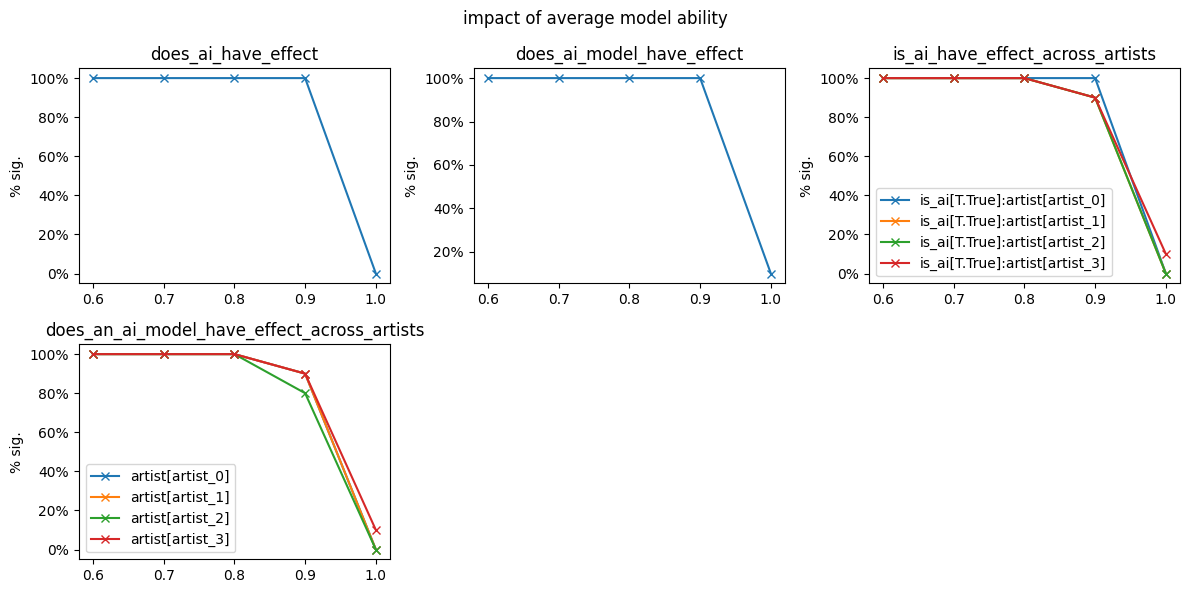

In [3]:
_ = pa.run_test_over_varying_parameters(
    10, 
    parameter_settings = {
        0.6: {'Model_ABILITIES' : [0.6 * np.ones(shape=4)]*3},
        0.7: {'Model_ABILITIES' : [0.7 * np.ones(shape=4)]*3},
        0.8: {'Model_ABILITIES' : [0.8 * np.ones(shape=4)]*3},
        0.9: {'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3},
        1.0: {'Model_ABILITIES' : [1.0 * np.ones(shape=4)]*3}
    },
    test_keys=[
        'does_ai_have_effect',
        'does_ai_model_have_effect',
        'is_ai_have_effect_across_artists',
        'does_an_ai_model_have_effect_across_artists'
    ],
    title='impact of average model ability'
)

### Varying # participants

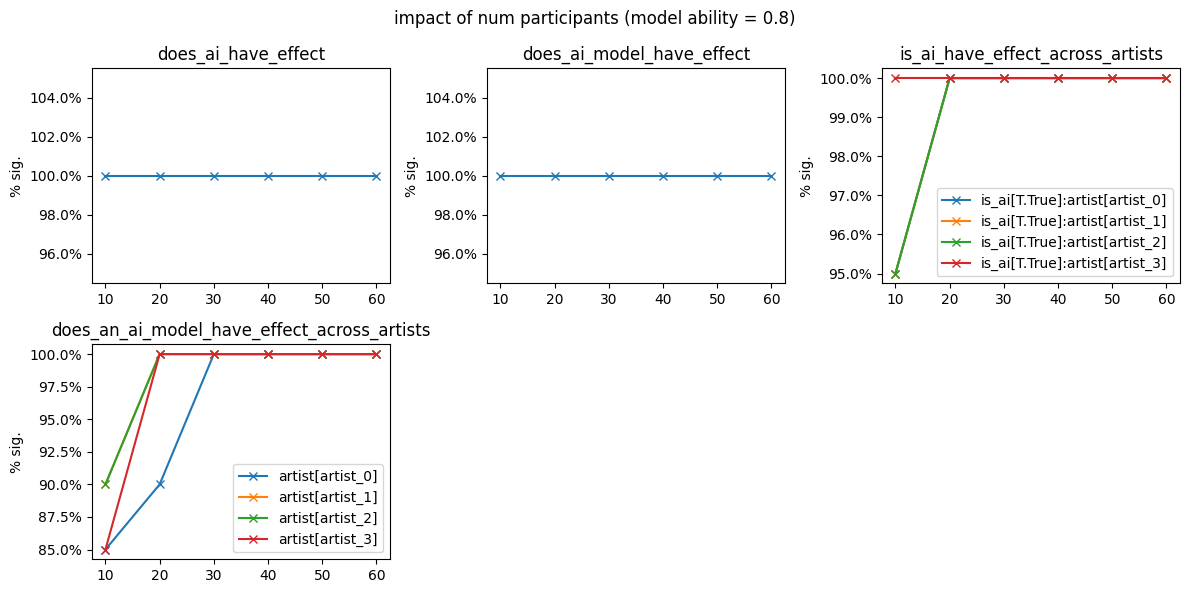

In [4]:
_ = pa.run_test_over_varying_parameters(
    20, 
    parameter_settings = {
        10: {'num_participants' : 10},
        20: {'num_participants' : 20},
        30: {'num_participants' : 30},
        40: {'num_participants' : 40},
        50: {'num_participants' : 50},
        60: {'num_participants' : 60}
    },
    test_keys=[
        'does_ai_have_effect',
        'does_ai_model_have_effect',
        'is_ai_have_effect_across_artists',
        'does_an_ai_model_have_effect_across_artists'
    ],
    title='impact of num participants (model ability = 0.8)'
)

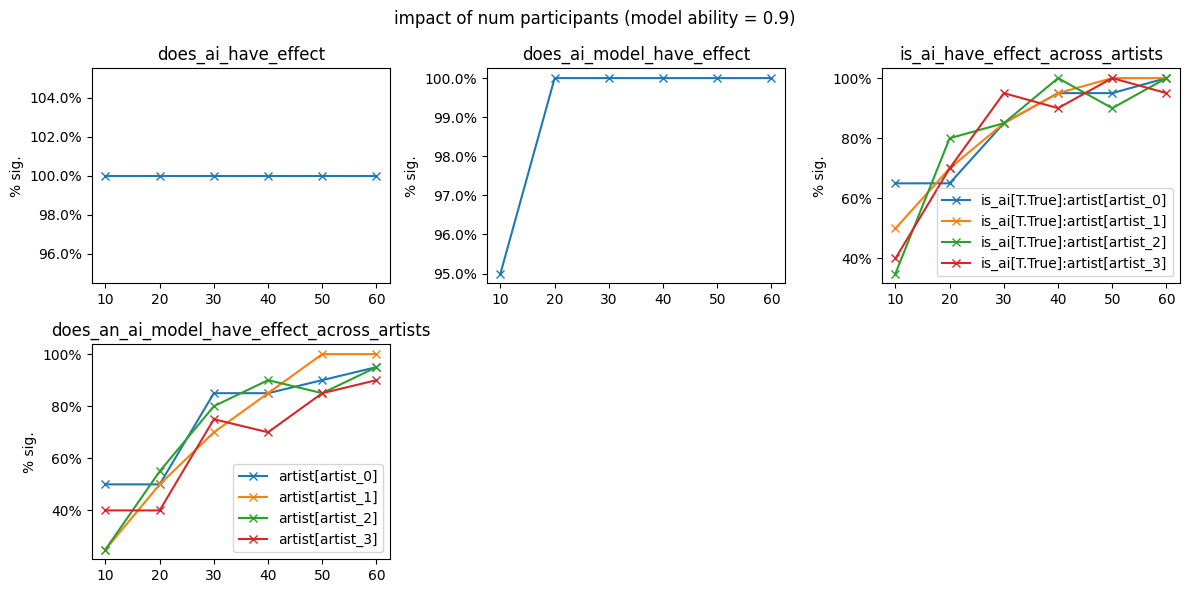

In [5]:
_ = pa.run_test_over_varying_parameters(
    20, 
    parameter_settings = {
        10: {'num_participants' : 10, 'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3},
        20: {'num_participants' : 20, 'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3},
        30: {'num_participants' : 30, 'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3},
        40: {'num_participants' : 40, 'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3},
        50: {'num_participants' : 50, 'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3},
        60: {'num_participants' : 60, 'Model_ABILITIES' : [0.9 * np.ones(shape=4)]*3}
    },
    test_keys=[
        'does_ai_have_effect',
        'does_ai_model_have_effect',
        'is_ai_have_effect_across_artists',
        'does_an_ai_model_have_effect_across_artists'
    ],
    title='impact of num participants (model ability = 0.9)'
)

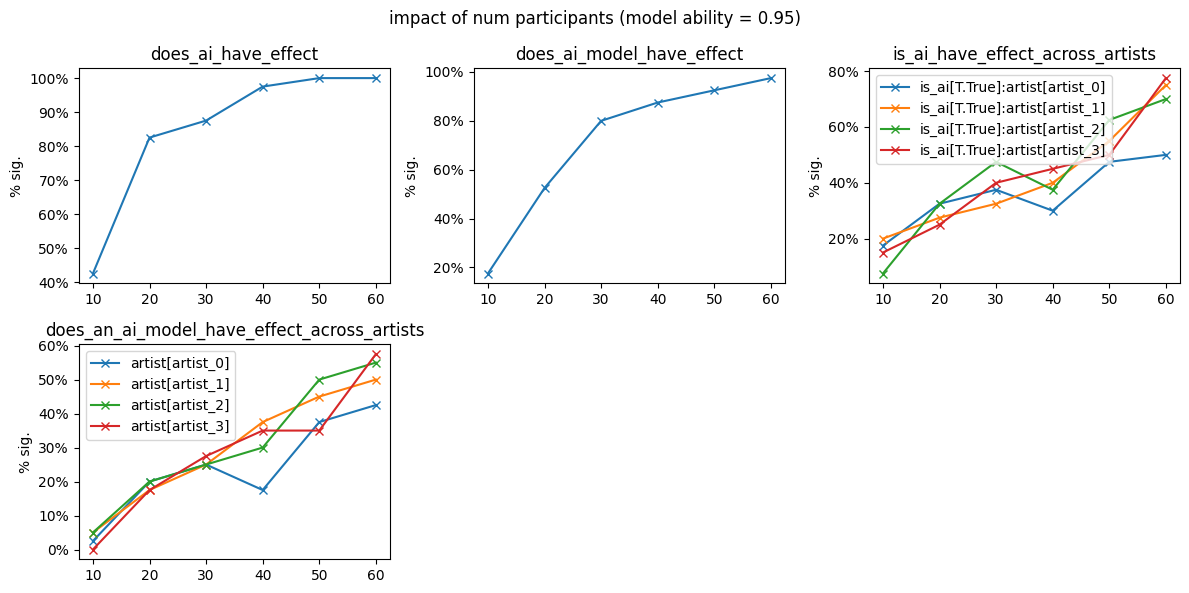

In [6]:
_ = pa.run_test_over_varying_parameters(
    40, 
    parameter_settings = {
        10: {'num_participants' : 10, 'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3},
        20: {'num_participants' : 20, 'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3},
        30: {'num_participants' : 30, 'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3},
        40: {'num_participants' : 40, 'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3},
        50: {'num_participants' : 50, 'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3},
        60: {'num_participants' : 60, 'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3}
    },
    test_keys=[
        'does_ai_have_effect',
        'does_ai_model_have_effect',
        'is_ai_have_effect_across_artists',
        'does_an_ai_model_have_effect_across_artists'
    ],
    title='impact of num participants (model ability = 0.95)'
)

### Can we detect variation between models?

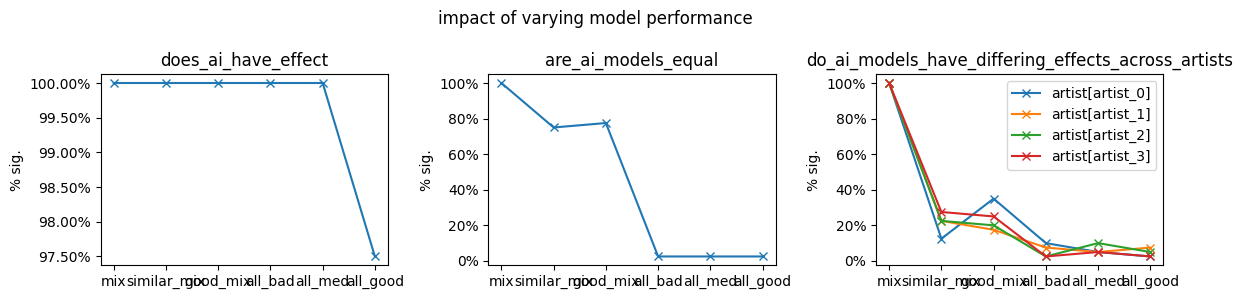

In [7]:
_ = pa.run_test_over_varying_parameters(
    40, 
    parameter_settings = {
        'mix': {'Model_ABILITIES' : [0.95 * np.ones(shape=4), 0.8 * np.ones(shape=4), 0.5 * np.ones(shape=4)]},
        'similar_mix': {'Model_ABILITIES' : [0.75 * np.ones(shape=4), 0.8 * np.ones(shape=4), 0.85 * np.ones(shape=4)]},
        'good_mix': {'Model_ABILITIES' : [0.85 * np.ones(shape=4), 0.9 * np.ones(shape=4), 0.95 * np.ones(shape=4)]},
        'all_bad': {'Model_ABILITIES' : [0.6 * np.ones(shape=4)]*3},
        'all_med': {'Model_ABILITIES' : [0.8 * np.ones(shape=4)]*3},
        'all_good': {'Model_ABILITIES' : [0.95 * np.ones(shape=4)]*3}
    },
    test_keys=[
        'does_ai_have_effect',
        'are_ai_models_equal',
        'do_ai_models_have_differing_effects_across_artists'
    ],
    title='impact of varying model performance'
)

# 'does_ai_have_effect',
#  'are_ai_models_equal',
#  'does_ai_model_have_effect',
#  'is_ai_have_effect_across_artists',
#  'does_an_ai_model_have_effect_across_artists',
#  'do_ai_models_have_differing_effects_across_artists',
#  'ai_influence_on_reasons',
#  'model_influence_on_reasons',
#  'ai_influence_on_reasons_across_artists',
#  'model_influence_on_reasons_across_artists'

### Is varying artist aspect weighting detectable?

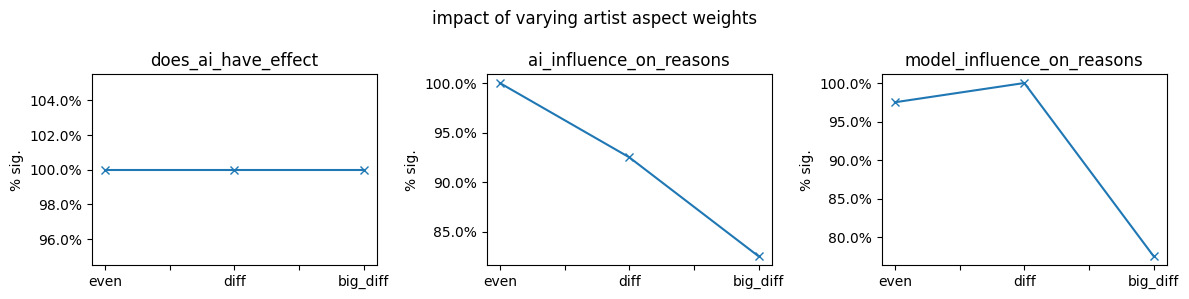

In [8]:
_ = pa.run_test_over_varying_parameters(
    40, 
    parameter_settings = {
        'even': {'ARTIST_ASPECT_WEIGHTING' : [ np.ones(shape=4)]*4},
        'diff': {'ARTIST_ASPECT_WEIGHTING' : [ [2,1,1,1], [1,2,1,1], [1,1,2,1], [1,1,1,2]] },
        'big_diff': {'ARTIST_ASPECT_WEIGHTING' : [ [4,1,1,1], [1,4,1,1], [1,1,4,1], [1,1,1,4]] },
    },
    test_keys=[
        'does_ai_have_effect',
        'ai_influence_on_reasons',
        'model_influence_on_reasons'
    ],
    title='impact of varying artist aspect weights'
)

Warning! The 'even' one above shouldn't return stat sig

### If all models are bad at one aspect, is that detectable?

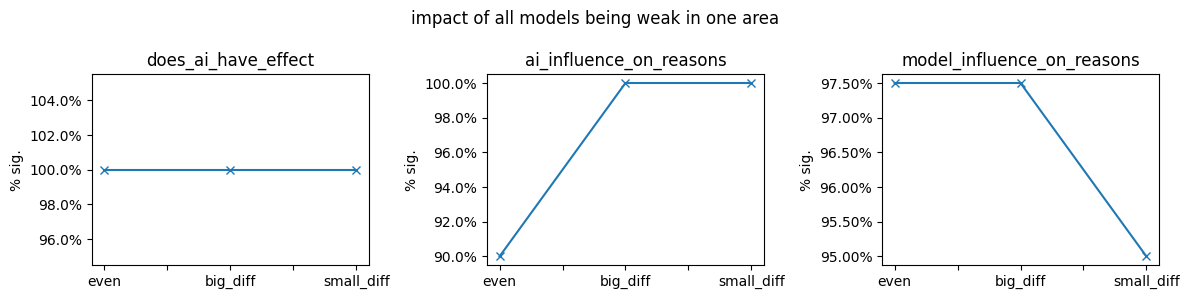

In [9]:
_ = pa.run_test_over_varying_parameters(
    40, 
    parameter_settings = {
        'even': {'Model_ABILITIES' : [0.8* np.ones(shape=4)]*3},
        'big_diff': {'Model_ABILITIES' : [[0.5, 0.9, 0.9, 0.9]]*3 },
        'small_diff': {'Model_ABILITIES' : [[0.7, 0.8, 0.8, 0.8]]*3 }
    },
    test_keys=[
        'does_ai_have_effect',
        'ai_influence_on_reasons',
        'model_influence_on_reasons'
    ],
    title='impact of all models being weak in one area'
)

Again, odd: the 'even' scenario shouldn't result in stat sig, let alone the highest power

### If we make each artist sensitive to a particular style aspect, and make all models have good performance only on one aspect, what happens?

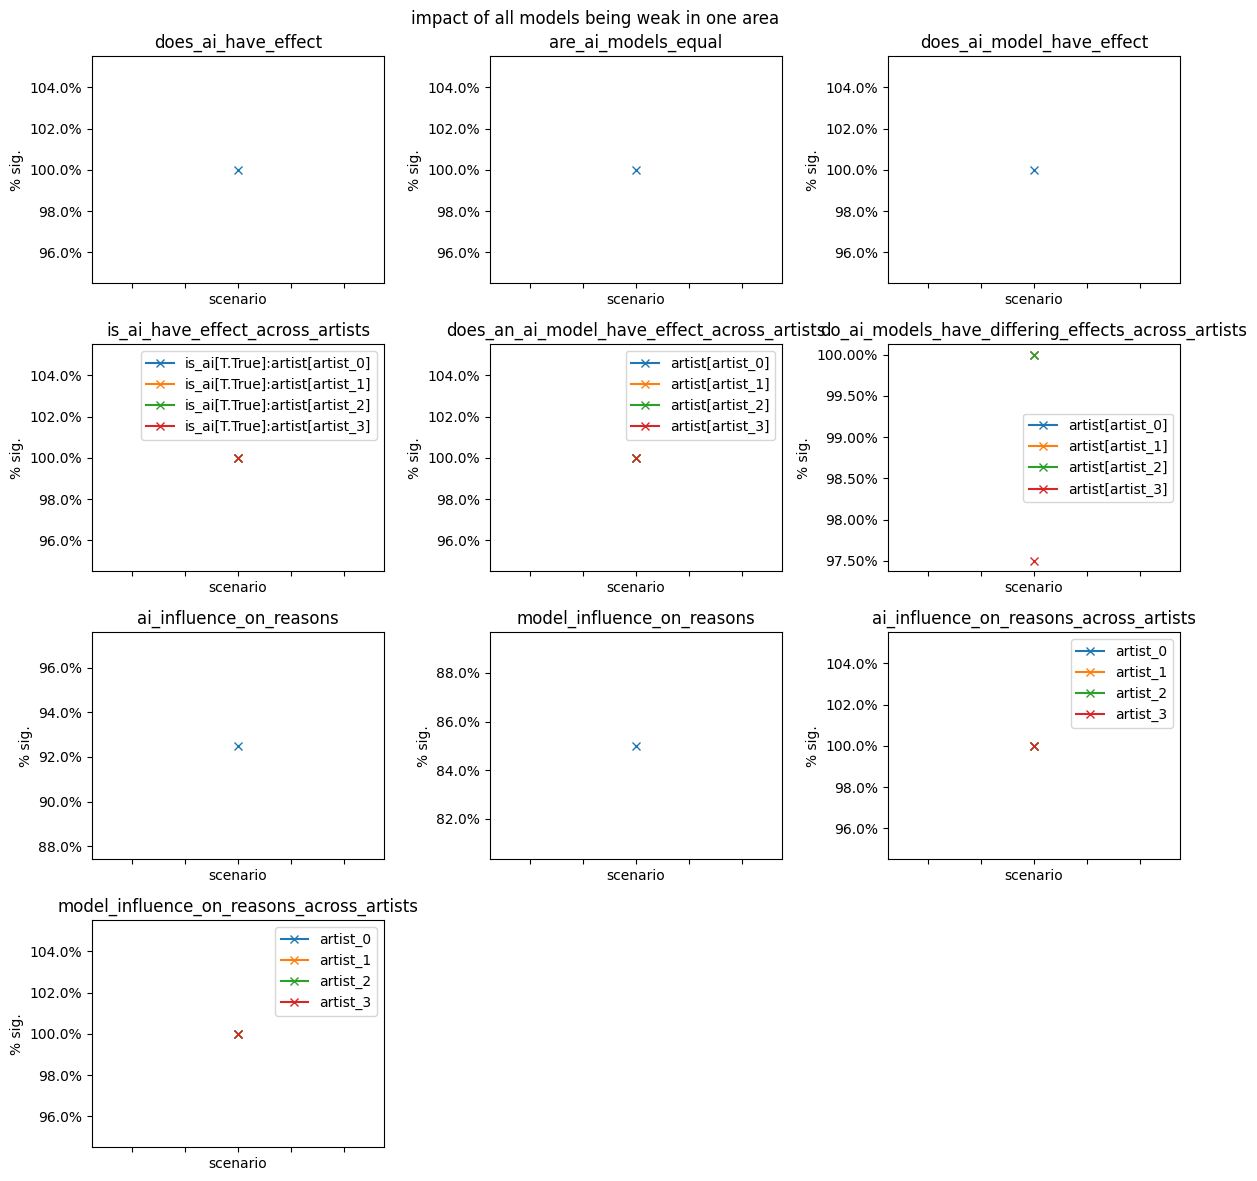

In [10]:
_ = pa.run_test_over_varying_parameters(
    40, 
    parameter_settings = {
        'scenario': {
            'Model_ABILITIES' : [0.95, 0.6, 0.6, 0.6]*3, 
            'ARTIST_ASPECT_WEIGHTING' : [ [4,1,1,1], [1,4,1,1], [1,1,4,1], [1,1,1,4]] 
        }
    },
    test_keys=[
        'does_ai_have_effect',
        'are_ai_models_equal',
        'does_ai_model_have_effect',
        'is_ai_have_effect_across_artists',
        'does_an_ai_model_have_effect_across_artists',
        'do_ai_models_have_differing_effects_across_artists',
        'ai_influence_on_reasons',
        'model_influence_on_reasons',
        'ai_influence_on_reasons_across_artists',
        'model_influence_on_reasons_across_artists'
    ],
    title='impact of all models being weak in one area'
)

## Some old stuff

In [11]:
# for k, v in formula_specifications.items():
#     cov_matrix = get_regression_matrix(formula_specifications[k], winners_losers_df)
#     print(k, np.linalg.matrix_rank(cov_matrix), len(cov_matrix.columns))
#     print(cov_matrix.columns)

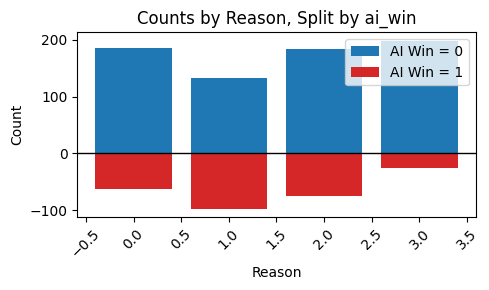

In [12]:
# check this out
sim_results = sim.generate_data_for_simulation()
# Build dataframe
df = pd.concat(
    [sim_results['outcomes']['reason'], sim_results['outcomes']['ai_win']],
    axis=1
).rename(columns={0: 'reason', 1: 'ai_win'})  # optional renaming

# Count occurrences
counts = df.groupby(['reason', 'ai_win']).size().unstack(fill_value=0)

# Extract the two series
win0 = counts[0]     # ai_win = 0
win1 = counts[1]     # ai_win = 1

# Make win1 negative so bars go downward
win1_neg = -win1

# Plot
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(win0.index, win0, label="AI Win = 0", color="tab:blue")
ax.bar(win1.index, win1_neg, label="AI Win = 1", color="tab:red")

# Formatting
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel("Count")
ax.set_xlabel("Reason")
ax.set_title("Counts by Reason, Split by ai_win")
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# possibility
# mod.get_margeff()